In [38]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns

In [39]:
def retrieve_data():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        milk = pd.read_sql_table('milk_volume', con)
        weather = pd.read_sql_table('weather', con)
        score = pd.read_sql_table('classification', con)
    return milk, weather, score

def merge_data(milk, weather, score):
    milk.reset_index()
    weather.reset_index()
    score.reset_index()
    m = pd.merge(left=milk, right=weather, left_on='date', right_on='date')
    m = pd.merge(left=m, right=score, left_on='animal_id', right_on='animal_id')
    m = m.reset_index()
    return m

def select_features(data):
    milk_features = ['milk_weight', 'average_flow', 'max_flow']
    weather_features =  ['tmax', 'tmin', 'is_hot', 'is_cold', 'is_heatwave', 'is_coldwave']
    score_features =  ['final_score', 'dairy_strength_aggregate', 'udder_score_aggregate', 'category']
    features = milk_features + weather_features + score_features
    data = data[features].dropna(axis=0, how='any')
    return pd.get_dummies(data, drop_first=True)

def get_data():
    milk, weather, score = retrieve_data()
    data = merge_data(milk, weather, score)
    return select_features(data)    

In [40]:
data = get_data()
data.sample(3)

,milk_weight,average_flow,max_flow,tmax,tmin,is_hot,is_cold,is_heatwave,is_coldwave,final_score,dairy_strength_aggregate,udder_score_aggregate,category_Fair,category_Good,category_Good Plus,category_Very Good
41444,25.8,5.00,7.6,83.0,66.0,False,False,False,False,80.0,83.0,83.0,0,0,1,0
153163,29.9,3.15,4.4,34.5,25.5,False,False,False,False,76.0,79.0,76.0,0,1,0,0
142516,42.1,3.65,5.8,78.5,56.5,False,False,False,False,74.0,83.0,81.0,1,0,0,0


In [41]:
y = data['milk_weight']
X = data.drop(labels=['milk_weight'], axis=1)

In [42]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [43]:
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='median', axis=0)),
         ('lasso', Lasso())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'lasso__alpha':np.arange(0.05, 1.0, 0.05)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
m_cv = GridSearchCV(pipeline, cv=3, param_grid=parameters)

# Fit to the training set
m_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = m_cv.score(X_test, y_test)
print("Tuned Lasso Alpha: {}".format(gm_cv.best_params_))
print("Tuned Lasso R squared: {}".format(r2))

y_pred = m_cv.predict(X_test)

Tuned Lasso Alpha: {'lasso__alpha': 0.050000000000000003}
Tuned Lasso R squared: 0.12156875194814032


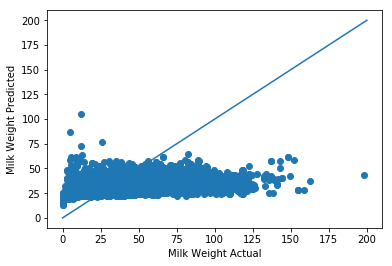

In [44]:
plt.scatter(y_test, y_pred)
plt.plot([0,200],[0,200])
plt.xlabel('Milk Weight Actual')
plt.ylabel('Milk Weight Predicted')
plt.show()